## Learning Rate Finder

For training deep neural networks, selecting a good learning rate is essential for both better performance and faster convergence. 
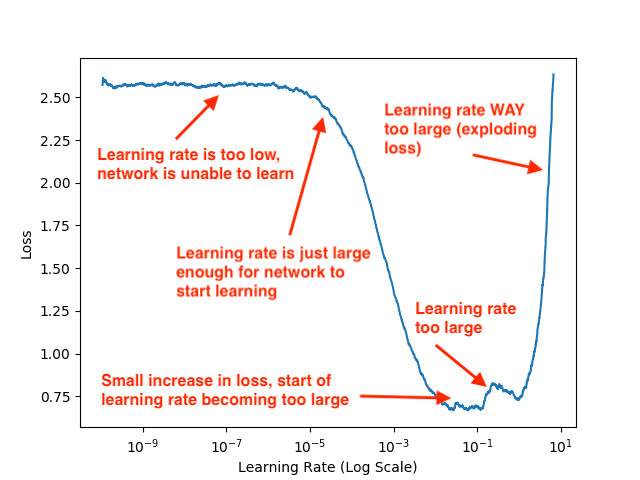

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision

In [34]:
class MyDataset(Dataset):
    def __init__(self,X,y,transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y

class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten()  # flatten llayer [b,c,h,w] -> [b, cxhxw]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, X):
        flatten_X = self.flatten(X)
        z1 = self.l1(flatten_X)
        a1 = F.relu(z1)
        x = self.l2(a1)

        return x
      

In [35]:
def learning(model, train_loader, val_loader, opt, loss_func, num_epochs, early_stopping=None, save_path=None):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(num_epochs):
        
        running_loss = 0
        running_val_loss = 0
        running_val_acc = 0
        
        for train_batch, data in enumerate(train_loader):
    
            X, y = data
            
            opt.zero_grad()
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
            
            loss.backward()
            opt.step()
    
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                
                X_val, y_val = data
                
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=1)==y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch+1))
        val_losses.append(running_val_loss/(val_batch+1))
        val_accuracies.append(running_val_acc/(val_batch +1))
    
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        # update best_val_losses and reset no_improve counter
        if val_losses[-1] < best_val_loss :
            best_val_loss = val_losses[-1]
            no_improve=0

            # save params
            if save_path is not None:
                state = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict':opt.state_dict(),
                    'val_loss':val_losses[-1]
                }
                torch.save(state, save_path)
            
        else:
            no_improve+=1

        # premature termination of the loop
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            idx = val_losses.index(best_val_loss)
            print(f'lowest validation error {best_val_loss}, validation accuracy {val_accuracies[idx]}, epoch {idx}')
            break

    return train_losses, val_losses, val_accuracies

In [36]:
num_epochs = 100
num_feature = 64
num_hidden = 30
num_class = 10

learning_rate = 0.1

model = MLP(num_feature, num_hidden, num_class)
opt = optim.SGD(params=model.parameters(), lr=learning_rate) # SGD : stochastic gradient descent algorithm

dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
images = images * (255. / 16.) # 0-16 -> 0-255
images = images.astype(np.uint8)
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),std=(0.5,))])

train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

train_losses, val_losses, val_accuracies = learning(model, train_loader, val_loader, opt, F.cross_entropy, num_epochs=100, early_stopping=5,save_path='./models/checkpoint')

epoch: 0: train error: 1.835457486576504, validation error: 1.280443161725998, validation accuracy: 0.7291666666666666
epoch: 1: train error: 0.8442588501506382, validation error: 0.5978751157720884, validation accuracy: 0.890625
epoch: 2: train error: 0.44037856062253317, validation error: 0.37381891409556073, validation accuracy: 0.90625
epoch: 3: train error: 0.3039955884218216, validation error: 0.27327698717514676, validation accuracy: 0.9244791666666666
epoch: 4: train error: 0.23277269221014446, validation error: 0.2229604652772347, validation accuracy: 0.9427083333333334
epoch: 5: train error: 0.1959646847512987, validation error: 0.18835646472871304, validation accuracy: 0.9479166666666666
epoch: 6: train error: 0.16911095115873548, validation error: 0.17357001826167107, validation accuracy: 0.9505208333333334
epoch: 7: train error: 0.15148563161492348, validation error: 0.17661108387013277, validation accuracy: 0.9453125
epoch: 8: train error: 0.13426670043004885, validation 

In [101]:
def learning_rate_finder(model, train_loader, loss_func, lr_multiplier=1.2):

    lr =1e-8
    max_lr = 10
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []
    lrs = []

    for train_batch, data in enumerate(train_loader):
   
        X, y = data
        
        opt.zero_grad()
        preds = model(X)
        loss = loss_func(preds, y)
        losses.append(loss.item())
        lrs.append(lr)
        
        loss.backward()
        opt.step()

        lr *=lr_multiplier

        #set new learning rate
        for param_group in opt.param_groups:
            param_group['lr'] = lr

        if lr > max_lr:
            break

    return lrs, losses

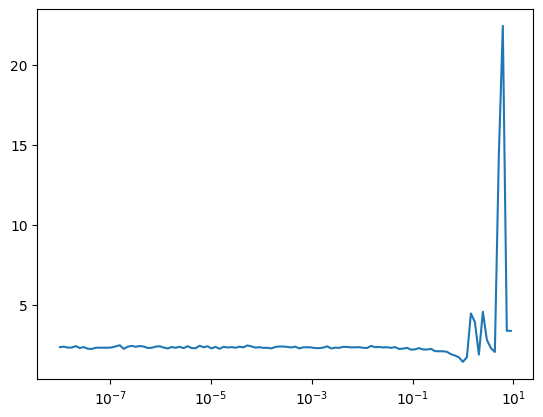

In [102]:
num_feature = 64
num_hidden = 30
num_class = 10

model = MLP(num_feature, num_hidden, num_class)

dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
images = images * (255. / 16.) # 0-16 -> 0-255
images = images.astype(np.uint8)
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),std=(0.5,))])

train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

lrs, losses = learning_rate_finder(model, train_loader, F.cross_entropy, lr_multiplier=1.2)
plt.plot(lrs, losses)
plt.xscale('log')

## Learning Rate Scheduler

Learnign rate scheduler dynamically adjusts the learning rate during training according to a predefined schedule

Reasons to use a learning rate scheduler
* Escaping from a local maximum
* Avoid using a low learning rate at beginning

How to use:
```python
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.9)

for epoch in range(20):
    for input, target in dataset:
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step()
```

[how to adjust learning rate](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

#### Test StepLr & CosineAnnealingLR
`lr_scheduler.StepLR` Decays the learning rate of each parameter group by gamma every step_size epochs.

`lr_scheduler.CosineAnnealingLR` 
Set the learning rate of each parameter group using a cosine annealing schedule, where $\eta_{max}$ is set to the initial lr and $T_{cur}$
  is the number of epochs since the last restart in SGDR:

In [105]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [112]:
num_feature = 64
num_hidden = 30
num_class = 10

learning_rate = 0.1

model = MLP(num_feature, num_hidden, num_class)
opt = optim.SGD(params=model.parameters(), lr=learning_rate) # SGD : stochastic gradient descent algorithm
scheduler = StepLR(opt, step_size=10, gamma=0.1)

print(f"learning rate before scheduler {opt.param_groups[0]['lr']}")
for epoch in range(30):
    scheduler.step()
print(f"learning rate after scheduler {opt.param_groups[0]['lr']}")

learning rate before scheduler 0.1
learning rate after scheduler 0.00010000000000000003


In [113]:
num_feature = 64
num_hidden = 30
num_class = 10

learning_rate = 0.1
lrs = []
model = MLP(num_feature, num_hidden, num_class)
opt = optim.SGD(params=model.parameters(), lr=learning_rate) # SGD : stochastic gradient descent algorithm
scheduler = CosineAnnealingLR(opt, T_max=50)

for epoch in range(150):
    lrs.append(opt.param_groups[0]['lr'])
    scheduler.step()

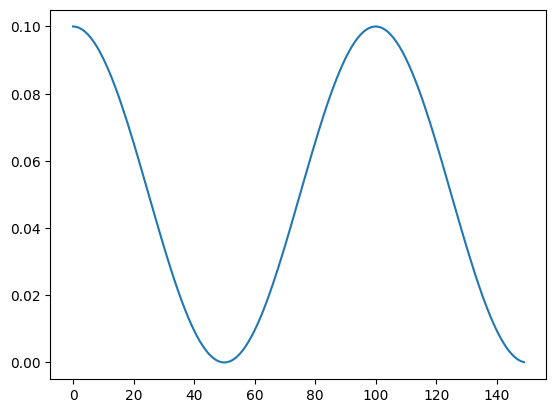

In [115]:
plt.plot(lrs)